# Test KL minimization with non-invertible transformation

In [1]:
import matplotlib.pyplot as plt
import torch

from gpsr.beams import NNDist

In [2]:
class Prior:
    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        x1 = x[:, 0]
        x2 = x[:, 1]
        return torch.sin(torch.pi * x1) - 2 * (x1**2 + x2**2 - 2.0) ** 2

In [3]:
ndim = 2
nsamp = 10_000

prior = Prior()

dist = NNDist(width=32, depth=2, ndim=ndim)
optimizer = torch.optim.Adam(dist.parameters(), lr=0.01)

history = {"loss": []}

for iteration in range(501):
    loss = -dist.entropy(nsamp, prior=prior)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    history["loss"].append(loss.item())

    if iteration % 50 == 0:
        print(iteration, loss)

0 tensor(11.8429, grad_fn=<NegBackward0>)
50 tensor(-1.1181, grad_fn=<NegBackward0>)
100 tensor(-1.4467, grad_fn=<NegBackward0>)
150 tensor(-1.5458, grad_fn=<NegBackward0>)
200 tensor(-1.5722, grad_fn=<NegBackward0>)
250 tensor(-1.5858, grad_fn=<NegBackward0>)
300 tensor(-1.5914, grad_fn=<NegBackward0>)
350 tensor(-1.5961, grad_fn=<NegBackward0>)
400 tensor(-1.6013, grad_fn=<NegBackward0>)
450 tensor(-1.6040, grad_fn=<NegBackward0>)
500 tensor(-1.6058, grad_fn=<NegBackward0>)


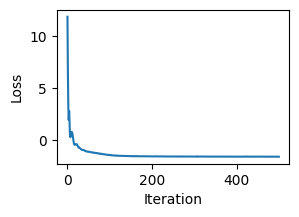

In [4]:
fig, ax = plt.subplots(figsize=(3.0, 2.0))
ax.plot(history["loss"])
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
plt.show()

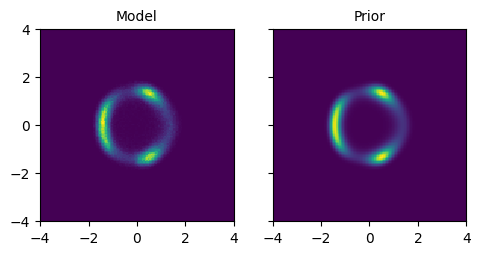

In [5]:
with torch.no_grad():
    grid_shape = (128, 128)
    grid_edges = [torch.linspace(-4.0, 4.0, n + 1) for n in grid_shape]
    grid_coords = [0.5 * (e[:-1] + e[1:]) for e in grid_edges]
    grid_points = torch.stack(
        [c.ravel() for c in torch.meshgrid(*grid_coords, indexing="ij")], axis=-1
    )
    grid_values = torch.exp(prior.log_prob(grid_points)).reshape(grid_shape)

    x = dist.sample(256_000)

    fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(5.5, 2.5))
    axs[0].hist2d(x[:, 0], x[:, 1], bins=grid_edges)
    axs[1].pcolormesh(grid_coords[0], grid_coords[1], grid_values.T)
    axs[0].set_title("Model", fontsize="medium")
    axs[1].set_title("Prior", fontsize="medium")
    plt.show()